Matriz de Admitância Y_bus:
21.457471-21.179707j  -21.457471+21.184707j  0.000000+0.000000j  0.000000+0.000000j  
-21.457471+21.184707j  231.053816-50.466483j  -15.384615+10.256410j  -194.211729+19.040366j  
0.000000+0.000000j  -15.384615+10.256410j  15.384615-10.251410j  0.000000+0.000000j  
0.000000+0.000000j  -194.211729+19.040366j  0.000000+0.000000j  194.211729-19.035366j  

Matriz de Impedância Z_bus (inversa da Y_bus reduzida):
Barras não-slack: [2, 3, 4]
Barra 2: Z22=0.023628+0.023300j  Z23=0.023636+0.023298j  Z24=0.023628+0.023299j  
Barra 3: Z32=0.023636+0.023298j  Z33=0.068659+0.053290j  Z34=0.023637+0.023297j  
Barra 4: Z42=0.023628+0.023299j  Z43=0.023637+0.023297j  Z44=0.028729+0.023798j  

--- Análise de Sensibilidade dos Modelos de Carga ---

Executando cenário: 100% Potência Constante

Constantes C:
C2 = -1.030600+0.000608j
C3 = -1.030754+0.000841j
C4 = -1.030603+0.000635j

Modelos de Carga Configurados:
Barra 2: 100.0% Potência Constante, 0.0% Corrente Constante, 0.0%

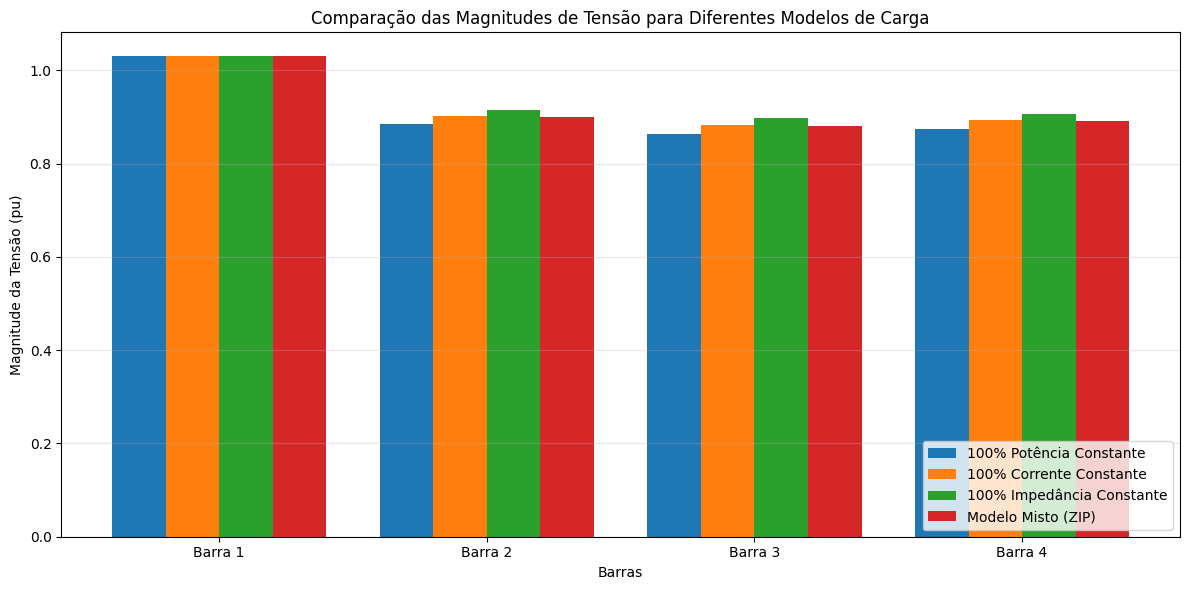

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from src.zmatrix_models import MetodoMatrizZdetailed

def exemplo_sistema_4_barras():
    # Definir o sistema
    barras = [1, 2, 3, 4]
    
    # Barra 1 é a slack (tipo 0)
    # Barras 2, 3 e 4 são PQ (tipo 2)
    barras_tipo = {1: 0, 2: 2, 3: 2, 4: 2}  # 0: slack, 1: PV, 2: PQ
    
    # Potências complexas (S = P + jQ) em pu
    # Nota: as cargas são negativas do ponto de vista da injeção de potência
    potencias = {
        1: 0.0 - 0.7j,  # Barra slack
        2: -1.28 - 1.28j,
        3: -0.32 - 0.16j,
        4: -1.6 - 0.80j
    }
    
    # Tensões iniciais (flat start com valores de 1.0 pu, exceto a barra slack)
    v_inicial = {
        1: 1.03 + 0.0j,  # Tensão de referência na barra slack
        2: 1.0 + 0.0j,
        3: 1.0 + 0.0j,
        4: 1.0 + 0.0j
    }
    
    # Definir os modelos de carga para cada barra (ZIP)
    # Formato: {barra: {'P': porcentagem_CP, 'I': porcentagem_CI, 'Z': porcentagem_CZ}}
    # Exemplo: Barra 2 com 60% potência constante, 30% corrente constante, 10% impedância constante
    # load_models = {
    #     1: {'P': 1.0, 'I': 0.0, 'Z': 0.0},  
    #     2: {'P': 1.0, 'I': 0.0, 'Z': 0.0},  
    #     3: {'P': 1.0, 'I': 0.0, 'Z': 0.0},  
    #     4: {'P': 1.0, 'I': 0.0, 'Z': 0.0},  
    # }
    
    # Linhas (conexões entre barras)
    linhas = [(1, 2), (2, 3), (2, 4)]
    
    # Calcular os elementos da matriz Y_bus
    
    # Impedâncias das linhas
    z12 = 0.0236 + 0.0233j
    z23 = 0.045 + 0.030j
    z24 = 0.0051 + 0.0005j
    
    # Admitâncias série das linhas
    y12 = 1 / z12
    y23 = 1 / z23
    y24 = 1 / z24
    
    # Admitância shunt total por linha (j0.01 pu)
    y_shunt = 0.01j
    
    # Construir a matriz de admitância Y_bus
    Y_bus = np.zeros((4, 4), dtype=complex)
    
    # Elementos diagonais (soma das admitâncias conectadas à barra)
    Y_bus[0, 0] = y12 + y_shunt/2  # Barra 1
    Y_bus[1, 1] = y12 + y23 + y24 + y_shunt/2 + y_shunt/2 + y_shunt/2  # Barra 2
    Y_bus[2, 2] = y23 + y_shunt/2  # Barra 3
    Y_bus[3, 3] = y24 + y_shunt/2  # Barra 4
    
    # Elementos não-diagonais (negativo da admitância entre as barras)
    Y_bus[0, 1] = Y_bus[1, 0] = -y12
    Y_bus[1, 2] = Y_bus[2, 1] = -y23
    Y_bus[1, 3] = Y_bus[3, 1] = -y24
    
    print("Matriz de Admitância Y_bus:")
    for i in range(4):
        row_str = ""
        for j in range(4):
            real = Y_bus[i, j].real
            imag = Y_bus[i, j].imag
            row_str += f"{real:.6f}{'+' if imag >= 0 else ''}{imag:.6f}j  "
        print(row_str)

    # Calcular e imprimir a matriz Z_bus (inversa da Y_bus reduzida)
    # Identifica a barra slack
    slack_bus = 1
    # Índices das barras não-slack
    barras_nao_slack = [b for b in barras if b != slack_bus]
    
    # Mapear índices originais para índices na matriz
    idx_map = {b: i for i, b in enumerate(barras)}
    idx_nao_slack = [idx_map[b] for b in barras_nao_slack]
    
    # Extrair a parte da Y_bus que corresponde às barras não-slack
    Y_reduzida = Y_bus[np.ix_(idx_nao_slack, idx_nao_slack)]
    
    # Calcular a matriz Z_bus (inversa da Y_bus reduzida)
    Z_bus = np.linalg.inv(Y_reduzida)
    
    print("\nMatriz de Impedância Z_bus (inversa da Y_bus reduzida):")
    print("Barras não-slack:", barras_nao_slack)
    for i, barra_i in enumerate(barras_nao_slack):
        row_str = f"Barra {barra_i}: "
        for j, barra_j in enumerate(barras_nao_slack):
            real = Z_bus[i, j].real
            imag = Z_bus[i, j].imag
            sign = "+" if imag >= 0 else ""
            row_str += f"Z{barra_i}{barra_j}={real:.6f}{sign}{imag:.6f}j  "
        print(row_str)
    
    # Tolerância conforme informado
    tolerancia = 0.0010
    
    # Criar instância do solver com os modelos de carga
    # solver = MetodoMatrizZdetailed(Y_bus, barras, linhas, barras_tipo, potencias, 
    #                            v_inicial, load_models=load_models, tol=tolerancia)
    
    # # Resolver usando método da matriz Z com substituição em bloco
    # v_bloco, v_history_bloco, iteracoes_bloco = solver.substituicao_em_bloco()
    # fluxos_bloco = solver.calcular_fluxos(v_bloco)
    
    # # Exibir resultados
    # solver.exibir_resultados(v_bloco, fluxos_bloco, "Substituição em Bloco", iteracoes_bloco)
    # solver.plotar_convergencia(v_history_bloco, "Substituição em Bloco")
    
    # # Resolver usando método da matriz Z com substituição direta
    # v_direta, v_history_direta, iteracoes_direta = solver.substituicao_direta()
    # fluxos_direta = solver.calcular_fluxos(v_direta)
    
    # # Exibir resultados
    # solver.exibir_resultados(v_direta, fluxos_direta, "Substituição Direta", iteracoes_direta)
    # solver.plotar_convergencia(v_history_direta, "Substituição Direta")
    
    # # Comparar número de iterações
    # print(f"\nComparação do número de iterações:")
    # print(f"Método de Substituição em Bloco: {iteracoes_bloco} iterações")
    # print(f"Método de Substituição Direta: {iteracoes_direta} iterações")
    
# Comparar resultados para diferentes combinações de modelos de carga
    print("\n--- Análise de Sensibilidade dos Modelos de Carga ---")
    
    # Definir diferentes cenários de modelos de carga
    load_scenarios = [
        {"name": "100% Potência Constante", "models": {
            1: {'P': 1.0, 'I': 0.0, 'Z': 0.0},
            2: {'P': 1.0, 'I': 0.0, 'Z': 0.0},
            3: {'P': 1.0, 'I': 0.0, 'Z': 0.0},
            4: {'P': 1.0, 'I': 0.0, 'Z': 0.0}
        }},
        {"name": "100% Corrente Constante", "models": {
            1: {'P': 0.0, 'I': 1.0, 'Z': 0.0},
            2: {'P': 0.0, 'I': 1.0, 'Z': 0.0},
            3: {'P': 0.0, 'I': 1.0, 'Z': 0.0},
            4: {'P': 0.0, 'I': 1.0, 'Z': 0.0}
        }},
        {"name": "100% Impedância Constante", "models": {
            1: {'P': 0.0, 'I': 0.0, 'Z': 1.0},
            2: {'P': 0.0, 'I': 0.0, 'Z': 1.0},
            3: {'P': 0.0, 'I': 0.0, 'Z': 1.0},
            4: {'P': 0.0, 'I': 0.0, 'Z': 1.0}
        }},
        {"name": "Modelo Misto (ZIP)", "models": {
            1: {'P': 0.4, 'I': 0.3, 'Z': 0.3},
            2: {'P': 0.4, 'I': 0.3, 'Z': 0.3},
            3: {'P': 0.4, 'I': 0.3, 'Z': 0.3},
            4: {'P': 0.4, 'I': 0.3, 'Z': 0.3}
        }}
    ]
    
    # Executar análise para cada cenário
    resultados_cenarios = []
    
    for scenario in load_scenarios:
        print(f"\nExecutando cenário: {scenario['name']}")
        solver_cenario = MetodoMatrizZdetailed(Y_bus, barras, linhas, barras_tipo, 
                                          potencias, v_inicial, 
                                          load_models=scenario['models'], 
                                          tol=tolerancia)
        
        # Usar método de substituição em bloco para todos os cenários
        v_final, _, iter_count = solver_cenario.substituicao_em_bloco()
        
        # Armazenar resultados
        v_magnitudes = [abs(v) for v in v_final]
        v_angulos = [np.angle(v, deg=True) for v in v_final]
        
        resultados_cenarios.append({
            "nome": scenario['name'],
            "iteracoes": iter_count,
            "magnitudes": v_magnitudes,
            "angulos": v_angulos
        })
    
    # Comparar resultados entre cenários
    print("\n--- Comparação de Resultados entre Cenários de Carga ---")
    print("{:<30} {:<10} {:<40} {:<40}".format(
        "Cenário", "Iterações", "Magnitudes de Tensão (pu)", "Ângulos de Fase (°)"))
    
    for resultado in resultados_cenarios:
        mags_str = ", ".join([f"{m:.4f}" for m in resultado["magnitudes"]])
        angs_str = ", ".join([f"{a:.2f}" for a in resultado["angulos"]])
        print("{:<30} {:<10} {:<40} {:<40}".format(
            resultado["nome"], resultado["iteracoes"], mags_str, angs_str))
    
    # Plotar comparação gráfica das magnitudes de tensão
    plt.figure(figsize=(12, 6))
    bar_width = 0.2
    x = np.arange(len(barras))
    
    for i, resultado in enumerate(resultados_cenarios):
        plt.bar(x + i*bar_width, resultado["magnitudes"], 
                width=bar_width, label=resultado["nome"])
    
    plt.xlabel('Barras')
    plt.ylabel('Magnitude da Tensão (pu)')
    plt.title('Comparação das Magnitudes de Tensão para Diferentes Modelos de Carga')
    plt.xticks(x + bar_width*1.5, [f'Barra {b}' for b in barras])
    plt.grid(True, axis='y', alpha=0.3)
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

exemplo_sistema_4_barras()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from src.zmatrix_models import MetodoMatrizZdetailed

def exemplo_sistema_4_barras():
    # Definir o sistema
    barras = [1, 2, 3, 4]
    
    # Barra 1 é a slack (tipo 0)
    # Barras 2, 3 e 4 são PQ (tipo 2)
    barras_tipo = {1: 0, 2: 2, 3: 2, 4: 2}  # 0: slack, 1: PV, 2: PQ
    
    # Potências complexas (S = P + jQ) em pu
    # Nota: as cargas são negativas do ponto de vista da injeção de potência
    potencias = {
        1: 0.0 - 0.7j,  # Barra slack
        2: -1.28 - 1.28j,
        3: -0.32 - 0.16j,
        4: -1.6 - 0.80j
    }
    
    # Tensões iniciais (flat start com valores de 1.0 pu, exceto a barra slack)
    v_inicial = {
        1: 0.72 + 0.0j,  # Tensão de referência na barra slack
        2: 1.0 + 0.0j,
        3: 1.0 + 0.0j,
        4: 1.0 + 0.0j
    }
    
    # Definir os modelos de carga para cada barra (ZIP)
    # Formato: {barra: {'P': porcentagem_CP, 'I': porcentagem_CI, 'Z': porcentagem_CZ}}
    # Exemplo: Barra 2 com 60% potência constante, 30% corrente constante, 10% impedância constante
    # load_models = {
    #     1: {'P': 1.0, 'I': 0.0, 'Z': 0.0},  
    #     2: {'P': 1.0, 'I': 0.0, 'Z': 0.0},  
    #     3: {'P': 1.0, 'I': 0.0, 'Z': 0.0},  
    #     4: {'P': 1.0, 'I': 0.0, 'Z': 0.0},  
    # }
    
    # Linhas (conexões entre barras)
    linhas = [(1, 2), (2, 3), (2, 4)]
    
    # Calcular os elementos da matriz Y_bus
    
    # Impedâncias das linhas
    z12 = 0.0236 + 0.0233j
    z23 = 0.045 + 0.030j
    z24 = 0.0051 + 0.0005j
    
    # Admitâncias série das linhas
    y12 = 1 / z12
    y23 = 1 / z23
    y24 = 1 / z24
    
    # Admitância shunt total por linha (j0.01 pu)
    y_shunt = 0.01j
    
    # Construir a matriz de admitância Y_bus
    Y_bus = np.zeros((4, 4), dtype=complex)
    
    # Elementos diagonais (soma das admitâncias conectadas à barra)
    Y_bus[0, 0] = y12 + y_shunt/2  # Barra 1
    Y_bus[1, 1] = y12 + y23 + y24 + y_shunt/2 + y_shunt/2 + y_shunt/2  # Barra 2
    Y_bus[2, 2] = y23 + y_shunt/2  # Barra 3
    Y_bus[3, 3] = y24 + y_shunt/2  # Barra 4
    
    # Elementos não-diagonais (negativo da admitância entre as barras)
    Y_bus[0, 1] = Y_bus[1, 0] = -y12
    Y_bus[1, 2] = Y_bus[2, 1] = -y23
    Y_bus[1, 3] = Y_bus[3, 1] = -y24
    
    print("Matriz de Admitância Y_bus:")
    for i in range(4):
        row_str = ""
        for j in range(4):
            real = Y_bus[i, j].real
            imag = Y_bus[i, j].imag
            row_str += f"{real:.6f}{'+' if imag >= 0 else ''}{imag:.6f}j  "
        print(row_str)

    # Calcular e imprimir a matriz Z_bus (inversa da Y_bus reduzida)
    # Identifica a barra slack
    slack_bus = 1
    # Índices das barras não-slack
    barras_nao_slack = [b for b in barras if b != slack_bus]
    
    # Mapear índices originais para índices na matriz
    idx_map = {b: i for i, b in enumerate(barras)}
    idx_nao_slack = [idx_map[b] for b in barras_nao_slack]
    
    # Extrair a parte da Y_bus que corresponde às barras não-slack
    Y_reduzida = Y_bus[np.ix_(idx_nao_slack, idx_nao_slack)]
    
    # Calcular a matriz Z_bus (inversa da Y_bus reduzida)
    Z_bus = np.linalg.inv(Y_reduzida)
    
    print("\nMatriz de Impedância Z_bus (inversa da Y_bus reduzida):")
    print("Barras não-slack:", barras_nao_slack)
    for i, barra_i in enumerate(barras_nao_slack):
        row_str = f"Barra {barra_i}: "
        for j, barra_j in enumerate(barras_nao_slack):
            real = Z_bus[i, j].real
            imag = Z_bus[i, j].imag
            sign = "+" if imag >= 0 else ""
            row_str += f"Z{barra_i}{barra_j}={real:.6f}{sign}{imag:.6f}j  "
        print(row_str)
    
    # Tolerância conforme informado
    tolerancia = 0.0010
    
    # Criar instância do solver com os modelos de carga
    # solver = MetodoMatrizZdetailed(Y_bus, barras, linhas, barras_tipo, potencias, 
    #                            v_inicial, load_models=load_models, tol=tolerancia)
    
    # # Resolver usando método da matriz Z com substituição em bloco
    # v_bloco, v_history_bloco, iteracoes_bloco = solver.substituicao_em_bloco()
    # fluxos_bloco = solver.calcular_fluxos(v_bloco)
    
    # # Exibir resultados
    # solver.exibir_resultados(v_bloco, fluxos_bloco, "Substituição em Bloco", iteracoes_bloco)
    # solver.plotar_convergencia(v_history_bloco, "Substituição em Bloco")
    
    # # Resolver usando método da matriz Z com substituição direta
    # v_direta, v_history_direta, iteracoes_direta = solver.substituicao_direta()
    # fluxos_direta = solver.calcular_fluxos(v_direta)
    
    # # Exibir resultados
    # solver.exibir_resultados(v_direta, fluxos_direta, "Substituição Direta", iteracoes_direta)
    # solver.plotar_convergencia(v_history_direta, "Substituição Direta")
    
    # # Comparar número de iterações
    # print(f"\nComparação do número de iterações:")
    # print(f"Método de Substituição em Bloco: {iteracoes_bloco} iterações")
    # print(f"Método de Substituição Direta: {iteracoes_direta} iterações")
    
# Comparar resultados para diferentes combinações de modelos de carga
    print("\n--- Análise de Sensibilidade dos Modelos de Carga ---")
    
    # Definir diferentes cenários de modelos de carga
    load_scenarios = [
        {"name": "100% Potência Constante", "models": {
            1: {'P': 1.0, 'I': 0.0, 'Z': 0.0},
            2: {'P': 1.0, 'I': 0.0, 'Z': 0.0},
            3: {'P': 1.0, 'I': 0.0, 'Z': 0.0},
            4: {'P': 1.0, 'I': 0.0, 'Z': 0.0}
        }},
        {"name": "100% Corrente Constante", "models": {
            1: {'P': 0.0, 'I': 1.0, 'Z': 0.0},
            2: {'P': 0.0, 'I': 1.0, 'Z': 0.0},
            3: {'P': 0.0, 'I': 1.0, 'Z': 0.0},
            4: {'P': 0.0, 'I': 1.0, 'Z': 0.0}
        }},
        {"name": "100% Impedância Constante", "models": {
            1: {'P': 0.0, 'I': 0.0, 'Z': 1.0},
            2: {'P': 0.0, 'I': 0.0, 'Z': 1.0},
            3: {'P': 0.0, 'I': 0.0, 'Z': 1.0},
            4: {'P': 0.0, 'I': 0.0, 'Z': 1.0}
        }},
        {"name": "Modelo Misto (ZIP)", "models": {
            1: {'P': 0.4, 'I': 0.3, 'Z': 0.3},
            2: {'P': 0.4, 'I': 0.3, 'Z': 0.3},
            3: {'P': 0.4, 'I': 0.3, 'Z': 0.3},
            4: {'P': 0.4, 'I': 0.3, 'Z': 0.3}
        }}
    ]
    
    # Executar análise para cada cenário
    resultados_cenarios = []
    
    for scenario in load_scenarios:
        print(f"\nExecutando cenário: {scenario['name']}")
        solver_cenario = MetodoMatrizZdetailed(Y_bus, barras, linhas, barras_tipo, 
                                          potencias, v_inicial, 
                                          load_models=scenario['models'], 
                                          tol=tolerancia)
        
        # Usar método de substituição em bloco para todos os cenários
        v_final, _, iter_count = solver_cenario.substituicao_em_bloco()
        
        # Armazenar resultados
        v_magnitudes = [abs(v) for v in v_final]
        v_angulos = [np.angle(v, deg=True) for v in v_final]
        
        resultados_cenarios.append({
            "nome": scenario['name'],
            "iteracoes": iter_count,
            "magnitudes": v_magnitudes,
            "angulos": v_angulos
        })
    
    # Comparar resultados entre cenários
    print("\n--- Comparação de Resultados entre Cenários de Carga ---")
    print("{:<30} {:<10} {:<40} {:<40}".format(
        "Cenário", "Iterações", "Magnitudes de Tensão (pu)", "Ângulos de Fase (°)"))
    
    for resultado in resultados_cenarios:
        mags_str = ", ".join([f"{m:.4f}" for m in resultado["magnitudes"]])
        angs_str = ", ".join([f"{a:.2f}" for a in resultado["angulos"]])
        print("{:<30} {:<10} {:<40} {:<40}".format(
            resultado["nome"], resultado["iteracoes"], mags_str, angs_str))
    
    # Plotar comparação gráfica das magnitudes de tensão
    plt.figure(figsize=(12, 6))
    bar_width = 0.2
    x = np.arange(len(barras))
    
    for i, resultado in enumerate(resultados_cenarios):
        plt.bar(x + i*bar_width, resultado["magnitudes"], 
                width=bar_width, label=resultado["nome"])
    
    plt.xlabel('Barras')
    plt.ylabel('Magnitude da Tensão (pu)')
    plt.title('Comparação das Magnitudes de Tensão para Diferentes Modelos de Carga')
    plt.xticks(x + bar_width*1.5, [f'Barra {b}' for b in barras])
    plt.grid(True, axis='y', alpha=0.3)
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

exemplo_sistema_4_barras()